In [1]:
import requests
import csv
import pandas as pd
import json
import ast

In [2]:
def create_csv(data_list, filename):
    all_keys = set()
    for item in data_list:
        all_keys.update(item.keys())
    with open(f'../data/{filename}', 'w', newline='', encoding='utf-8') as output_file:
        dict_writer = csv.DictWriter(output_file, all_keys)
        dict_writer.writeheader()
        dict_writer.writerows(data_list)

### Circuits

In [3]:

def get_circuits(limit, offset):
    results_response = requests.get(f'https://ergast.com/api/f1/circuits.json', params={"limit": limit, "offset": offset})
    results = results_response.json()
    return results.get("MRData", {}).get("CircuitTable", {}).get("Circuits", [])

all_results = []


limit = 100  # Num of results per page
offset = 0  # Results init

while True:
    results_season = get_circuits(limit, offset)
    if not results_season:
        break

    all_results.extend(results_season)
    offset += limit

create_csv(all_results, 'drivers_2020-2024.csv')


### Drivers

In [5]:

def get_drivers(season, limit, offset):
    results_response = requests.get(f'https://ergast.com/api/f1/{season}/drivers.json', params={"limit": limit, "offset": offset})
    results = results_response.json()
    return results.get("MRData", {}).get("DriverTable", {}).get("Drivers", [])

season_range = range(2000,2025)
all_results = []

for season in season_range:
    limit = 100  # Num of results per page
    offset = 0  # Results init

    while True:
        results_season = get_drivers(season, limit, offset)
        if not results_season:
            break

        all_results.extend(results_season)        
        offset += limit

create_csv(all_results, 'drivers_2020-2024.csv')


### Races

In [6]:

def get_races(season, limit, offset):
    results_response = requests.get(f'https://ergast.com/api/f1/{season}/races.json', params={"limit": limit, "offset": offset})
    results = results_response.json()
    return results.get("MRData", {}).get("RaceTable", {}).get("Races", [])

season_range = range(2000,2025)
all_results = []

for season in season_range:
    limit = 100  # Num of results per page
    offset = 0  # Results init

    while True:
        results_season = get_races(season, limit, offset)
        if not results_season:
            break

        all_results.extend(results_season)
        offset += limit

create_csv(all_results, 'races_2020-2024.csv')


### Race Results

In [123]:

def get_results(season, limit, offset):
    results_response = requests.get(f'https://ergast.com/api/f1/{season}/results.json', params={"limit": limit, "offset": offset})
    results = results_response.json()
    return results.get("MRData", {}).get("RaceTable", {}).get("Races", [])

season_range = range(2000,2025)
all_results = []

for season in season_range:
    limit = 100  # Num of results per page
    offset = 0  # Results init

    while True:
        results_season = get_results(season, limit, offset)
        if not results_season:
            break

        all_results.extend(results_season)
        
        offset += limit

create_csv(all_results, 'results_2020-2024.csv')


In [125]:
# Format CSV

df_race_results = pd.read_csv('../data/results_2020-2024.csv')

df_race_results['Results'] = df_race_results['Results'].apply(ast.literal_eval)

rows = []
results_expanded = []
for index, row in df_race_results.iterrows():
    results_list = row['Results']
    for result in results_list:
        rows.append(row.drop('Results'))
        results_expanded.append(result)

expanded_rows_df = pd.DataFrame(rows)
results_normalized_df = pd.json_normalize(results_expanded)

drivers_results_df = pd.concat([expanded_rows_df.reset_index(drop=True), results_normalized_df.reset_index(drop=True)], axis=1)

drivers_results_df['points'] = pd.to_numeric(drivers_results_df['points'], errors='coerce') # convert to integer

## Circuits
drivers_results_df['Circuit'] = drivers_results_df['Circuit'].apply(ast.literal_eval)
# print(type(drivers_results_df['Circuit'].iloc[0]))
circuits_normalized = pd.json_normalize(drivers_results_df['Circuit'])

drivers_results_df = pd.concat([drivers_results_df.drop(columns=['Circuit']), circuits_normalized],axis=1)

drivers_results_df.drop(columns=['url', 'Location.lat',	'Location.long', 'Location.locality', 'Location.country', 'Driver.url', 'time'], axis=1, inplace=True)

drivers_results_df.to_csv('../data/cleaned_results_2020-2024.csv', index=False)


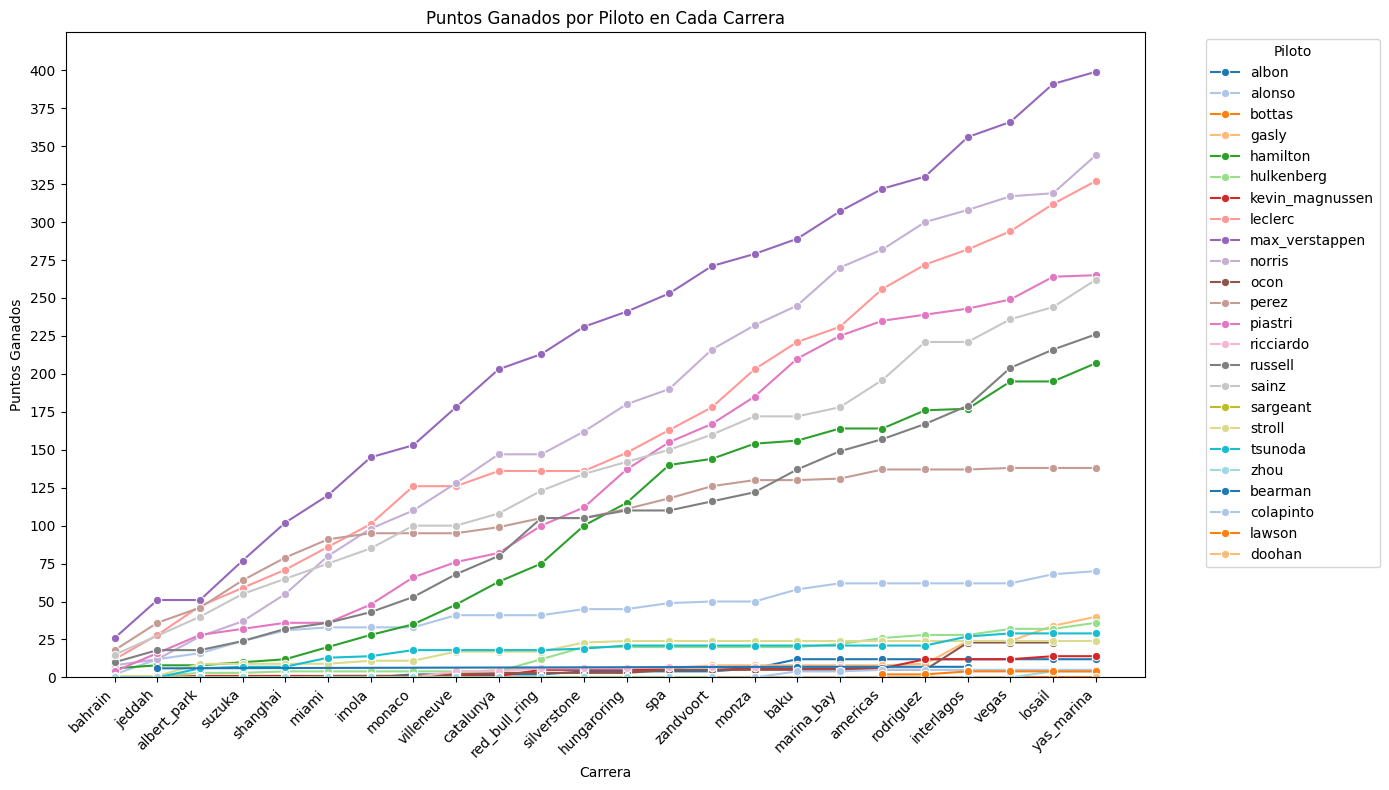

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
formatted_results = pd.read_csv('../data/cleaned_results_2020-2024.csv')

# Order by season, round, driverId
formatted_results = formatted_results.sort_values(by=['season', 'round', 'Driver.driverId'])

# Calculate accumulated by drivers per season
formatted_results['cumulative_points'] = formatted_results.groupby(['season','Driver.driverId'])['points'].cumsum()

# Crear el lineplot
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=formatted_results[formatted_results.season == 2024], 
    x='circuitId',
    y='cumulative_points',
    hue='Driver.driverId',
    marker='o',
    palette='tab20'      
)
# Personalizar el gráfico
plt.title('Puntos Ganados por Piloto en Cada Carrera')
plt.xlabel('Carrera')
plt.ylabel('Puntos Ganados')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Piloto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.ylim(0,425)
plt.yticks(range(0, 425, 25))  # Intervals and jumps


# Display plot
plt.show()

### Sprint Races

In [125]:
def get_results(season, limit, offset):
    results_response = requests.get(f'https://ergast.com/api/f1/{season}/sprint.json', params={"limit": limit, "offset": offset})
    results = results_response.json()
    return results.get("MRData", {}).get("RaceTable", {}).get("Races", [])

season_range = range(2000,2025)
all_sprint_results = []

for season in season_range:
    limit = 100  # Num of results per page
    offset = 0  # Results init

    while True:
        sprint_results_season = get_results(season, limit, offset)
        if not sprint_results_season:
            break

        all_sprint_results.extend(sprint_results_season)
        
        offset += limit

create_csv(all_sprint_results, 'sprint_results_2020-2024.csv')

### Qualifying results

In [129]:
def get_results(season, limit, offset):
    results_response = requests.get(f'https://ergast.com/api/f1/{season}/qualifying.json', params={"limit": limit, "offset": offset})
    results = results_response.json()
    return results.get("MRData", {}).get("RaceTable", {}).get("Races", [])

season_range = range(2000,2025)
all_qualy_results = []

for season in season_range:
    limit = 100  # Num of results per page
    offset = 0  # Results init

    while True:
        qualy_results_season = get_results(season, limit, offset)
        if not qualy_results_season:
            break

        all_qualy_results.extend(qualy_results_season)
        
        offset += limit

create_csv(all_qualy_results, 'qualy_results_2020-2024.csv')